In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
import networkx as nx
from tqdm import tqdm
import powerlaw

C:\Users\Joao\AppData\Local\Temp\ipykernel_31376\2951664998.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(p, np.sqrt((1-p)/(1000*p)))


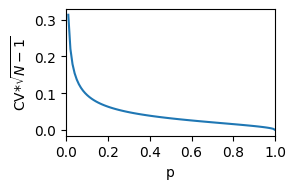

In [2]:
# Plot (sqrt((1-p)/np)) vs p
plt.figure(figsize=(3, 2))
p = np.linspace(0, 1, 100)
plt.plot(p, np.sqrt((1-p)/(1000*p)))
plt.xlabel('p')
plt.ylabel(r'CV*$\sqrt{N-1}$')
#autoscale x-axis
plt.tight_layout()
plt.xlim(0, 1);

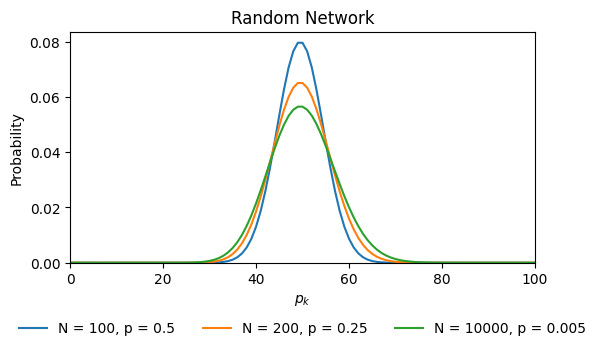

In [3]:
# Plots binomial degree spread of a random network
plt.figure(figsize=(6, 3))

def plot_binomial_distribution(N, p):
    x = np.arange(0, N+1)
    y = binom.pmf(x, N-1, p)
    plt.plot(x, y, label='N = {}, p = {}'.format(N, p))


# Plot for N = 100, 200, 10000
plot_binomial_distribution(100, 0.5)
plot_binomial_distribution(200, 0.25)
plot_binomial_distribution(10000, 0.005)
plt.xlim(0, 100)
plt.ylim(bottom=0)
plt.xlabel(r'$p_k$')
plt.ylabel('Probability')
plt.title('Random Network')
# plots the legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False);

In [4]:
from scipy.special import lambertw

# Calculates the max path length for a given N and p of the random network, taken from https://ar5iv.labs.arxiv.org/html/0808.4067 (eq. 1.5)
def max_path_length(N, K):
    p = K/(N-1)
    lambda_ = N*p
    lambda_star = lambertw(lambda_*np.exp(-lambda_)).real
    return np.ceil(np.log(N)/np.log(lambda_)) + 2*np.floor(np.log(N)/np.log(1/lambda_star)) + 1

print('Max path length:', max_path_length(8e9, 150))
print('Average path length:', 0.5+(np.log(8e9)-0.5772)/np.log(150))

Max path length: 6.0
Average path length: 4.93566655206642


In [5]:
#Network creation functions

# BA graph with no growth (V1)
def create_network(N, K):
    G = nx.Graph()
    G.add_nodes_from(range(N))  # All nodes are available at the beginning

    for _ in tqdm(range(N*K)):
        nodes = list(G.nodes)
        random_node1 = np.random.choice(nodes)  # Randomly select one node

        degrees = [d for n, d in G.degree(nodes)]  # Degree of each node
        total_degree = sum(degrees)  # Total degree

        # Probability for each node to be selected
        probabilities = [d / total_degree if total_degree > 0 else 1/N for d in degrees]

        random_node2 = np.random.choice(nodes, p=probabilities)  # Select the other node through preferential attachment

        G.add_edge(random_node1, random_node2)  # Add edge between the two nodes

    return G

# BA graph with no growth (V2)
def create_network2(N, K):
    G = nx.Graph()
    G.add_nodes_from(range(N))  # All nodes are available at the beginning

    for _ in tqdm(range(N*K)):
        nodes = list(G.nodes)
        random_node1 = np.random.choice(nodes)  # Randomly select one node

        degrees = [d for n, d in G.degree(nodes)]  # Degree of each node
        total_degree = sum(degrees)  # Total degree

        # Probability for each node to be selected. Adds +1 to each degree to avoid division by 0
        probabilities = [(d+1) / (total_degree+N) for d in degrees] 

        random_node2 = np.random.choice(nodes, p=probabilities)  # Select the other node through preferential attachment

        G.add_edge(random_node1, random_node2)  # Add edge between the two nodes

    return G

# BA graph with non-linear preferential attachment
def create_network_nonlinear_growing(N, M, alpha):
    G = nx.Graph()

    # Start with a fully connected network of M nodes
    for i in range(M):
        for j in range(i):
            G.add_edge(i, j)

    for node in tqdm(range(M, N)):
        degrees = [d for n, d in G.degree(G.nodes)]  # Degree of each node
        total_degree_alpha = sum(d**alpha for d in degrees)  # Total of degree**alpha

        # Probability for each node to be selected
        probabilities = [d**alpha / total_degree_alpha if total_degree_alpha > 0 else 1/len(G.nodes) for d in degrees]

        # Select M nodes through non-linear preferential attachment without replacement
        selected_nodes = np.random.choice(list(G.nodes), size=M, replace=False, p=probabilities)

        # Add the new node and edges to the selected nodes
        G.add_node(node)
        for selected_node in selected_nodes:
            G.add_edge(node, selected_node)

    return G

# BA graph with fitness
def create_network_fitness(N, M, node_fitness):
    G = nx.Graph()

    # Start with a fully connected network of M nodes
    for i in range(M):
        for j in range(i):
            G.add_edge(i, j)

    for node in tqdm(range(M, N)):
        degrees = [d for n, d in G.degree(G.nodes)]  # Degree of each node
        total_degree_fitness = sum(d*node_fitness[n] for n, d in G.degree(G.nodes))  # Total of degree*fitness

        # Probability for each node to be selected
        probabilities = [d*node_fitness[n] / total_degree_fitness if total_degree_fitness > 0 else 1/len(G.nodes) for n, d in G.degree(G.nodes)]

        # Select M nodes through preferential attachment without replacement
        selected_nodes = np.random.choice(list(G.nodes), size=M, replace=False, p=probabilities)

        # Add the new node and edges to the selected nodes
        G.add_node(node)
        for selected_node in selected_nodes:
            G.add_edge(node, selected_node)

    return G

#removes zeroes and plots it
def plot_degree(G, label, linear_bins=False, **kwargs):
    degree = [d for n, d in G.degree()]
    degree = np.array(degree)
    degree = degree[degree!=0]
    powerlaw.plot_pdf(degree, label=label, linear_bins=linear_bins, **kwargs)
    #print(degree.sum())

# Plots the unbinned degree distribution of a network
def plot_degree_unbinned(G, label):
    degree = [d for n, d in G.degree()]
    degree = np.array(degree)
    degree = degree[degree!=0]
    degree = np.unique(degree, return_counts=True)
    plt.scatter(degree[0], degree[1]/degree[1].sum(), label=label, s=10)

100%|██████████| 40000/40000 [02:49<00:00, 235.69it/s]


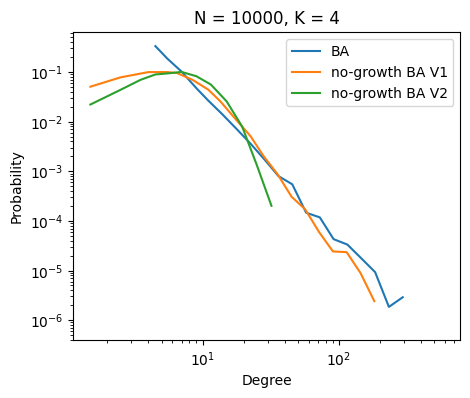

In [6]:
# Compares the no-growth BA networks
N = 10000
K = 4
G = create_network(N, K)
G2 = create_network2(N, K)
G_ba = nx.barabasi_albert_graph(N, K)

plt.figure(figsize=(5, 4))
plot_degree(G_ba, 'BA')
plot_degree(G, 'no-growth BA V1')
plot_degree(G2, 'no-growth BA V2')

plt.legend()
plt.title('N = {}, K = {}'.format(N, K))
plt.xlabel('Degree')
plt.ylabel('Probability');

100%|██████████| 9996/9996 [00:30<00:00, 323.58it/s] 


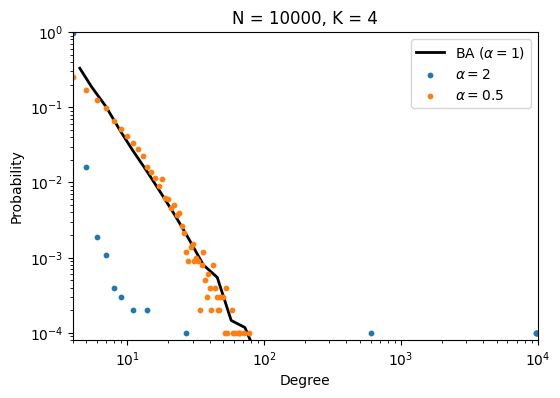

In [7]:
# Compares the non-linear BA networks
G_alpha2 = create_network_nonlinear_growing(10000, 4, 2)
G_alpha05 = create_network_nonlinear_growing(10000, 4, 0.5)

plt.figure(figsize=(6, 4))
plot_degree(G_ba, r'BA ($\alpha = 1$)', linear_bins=False, **{'zorder': 1, 'linewidth': 2, 'color': 'k'})
plot_degree_unbinned(G_alpha2, r'$\alpha = 2$')
plot_degree_unbinned(G_alpha05, r'$\alpha = 0.5$')
#plot_degree_unbinned(G_alpha03, r'$\alpha = 0.3$')

plt.legend()
plt.title('N = {}, K = {}'.format(N, K))
plt.xlabel('Degree')
plt.ylabel('Probability');
plt.xscale('log')
plt.yscale('log')
plt.xlim(4, 10000)
plt.ylim(8e-5, 1);

C:\Users\Joao\AppData\Local\Temp\ipykernel_31376\2723995971.py:6: RuntimeWarning: invalid value encountered in power
  Pk = [(2+A/m)*np.power((k+A)/(m+A), -3-A/m) for k in K]
C:\Users\Joao\AppData\Local\Temp\ipykernel_31376\2723995971.py:6: RuntimeWarning: divide by zero encountered in power
  Pk = [(2+A/m)*np.power((k+A)/(m+A), -3-A/m) for k in K]


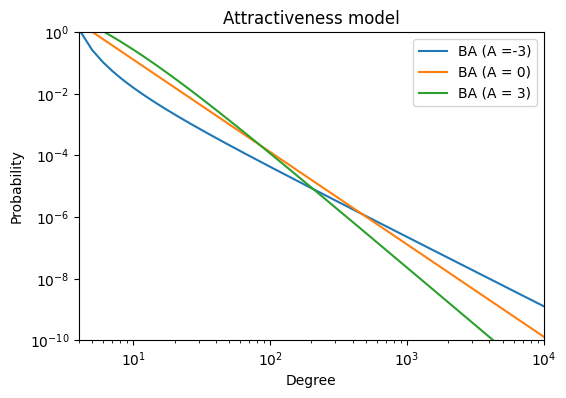

In [8]:
# Compares the BA networks with different attractiveness

def plot_attractiveness(Kmax, m, A, label):
    K = np.arange(1, Kmax+1)

    Pk = [(2+A/m)*np.power((k+A)/(m+A), -3-A/m) for k in K]

    plt.plot(K, Pk, label=label)

plt.figure(figsize=(6, 4))
plot_attractiveness(10000,4,-3, 'BA (A =-3)')
plot_attractiveness(10000,4,0, 'BA (A = 0)')
plot_attractiveness(10000,4,3, 'BA (A = 3)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.legend()
plt.xlim(4, 10000)
plt.ylim(1e-10, 1)
plt.title('Attractiveness model');

100%|██████████| 9996/9996 [01:01<00:00, 163.28it/s] 


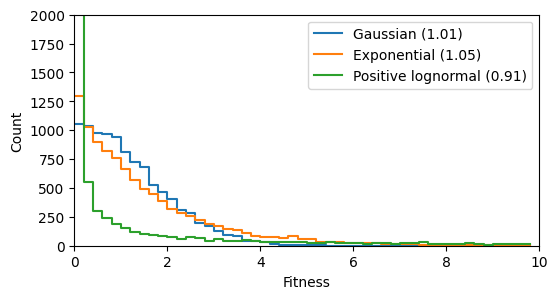

In [9]:
# Compares BA networks with gaussian and exponential fitness
N = 10000
K = 4
fitness_gaussian = np.abs(np.random.normal(0, 1.5, N))
fitness_exponential = np.random.exponential(1.5, N)
fitness_positive_lognormal = np.random.lognormal(0, 5, N)

# plots the fitness distributions with bins=np.arange(0, 10, 0.1) and no color under the bars
def plot_fitness(fitness, label):
    bins, edges = np.histogram(fitness, bins=np.arange(0, 10, 0.2))
    left, right = edges[:-1], edges[1:]
    X = np.array([left, right]).T.flatten()
    Y = np.array([bins, bins]).T.flatten()
    plt.plot(X, Y, label=label)

plt.figure(figsize=(6, 3))
plot_fitness(fitness_gaussian, 'Gaussian ({:0.2f})'.format(np.median(fitness_gaussian)))
plot_fitness(fitness_exponential, 'Exponential ({:0.2f})'.format(np.median(fitness_exponential)))
plot_fitness(fitness_positive_lognormal, 'Positive lognormal ({:0.2f})'.format(np.median(fitness_positive_lognormal)))
plt.xlim(0, 10)
plt.ylim(0, 2000)
plt.legend()

plt.xlabel('Fitness')
plt.ylabel('Count')

G_exponential = create_network_fitness(N, K, fitness_exponential)
G_gaussian = create_network_fitness(N, K, fitness_gaussian)
G_positive_lognormal = create_network_fitness(N, K, fitness_positive_lognormal)

Text(0, 0.5, 'Count')

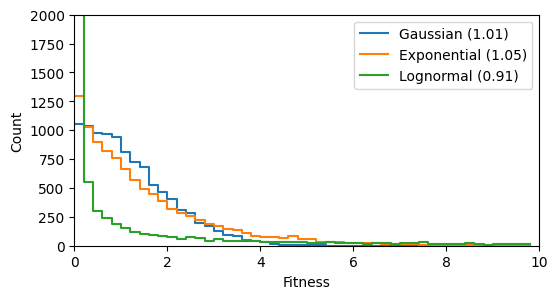

In [10]:
plt.figure(figsize=(6, 3))
plot_fitness(fitness_gaussian, 'Gaussian ({:0.2f})'.format(np.median(fitness_gaussian)))
plot_fitness(fitness_exponential, 'Exponential ({:0.2f})'.format(np.median(fitness_exponential)))
plot_fitness(fitness_positive_lognormal, 'Lognormal ({:0.2f})'.format(np.median(fitness_positive_lognormal)))
plt.xlim(0, 10)
plt.ylim(0, 2000)
plt.legend()

plt.xlabel('Fitness')
plt.ylabel('Count')

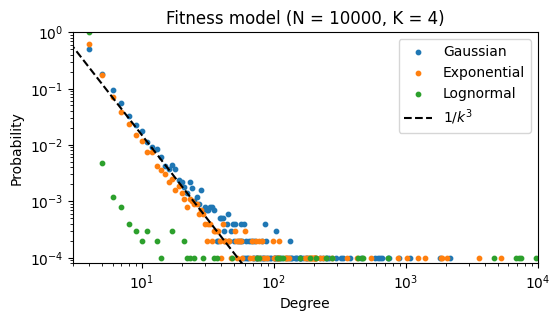

In [11]:
# plots the degree distributions
plt.figure(figsize=(6, 3))
plot_degree_unbinned(G_gaussian, 'Gaussian')
plot_degree_unbinned(G_exponential, 'Exponential')
plot_degree_unbinned(G_positive_lognormal, 'Lognormal')
# plots 1/x^3
plt.plot(np.arange(1, 1000), 15/np.arange(1, 1000)**3, '--', label=r'$1/k^3$', color='k')
plt.title('Fitness model (N = {}, K = {})'.format(N, K))
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.xlim(3, 10000)
plt.ylim(8e-5, 1)
plt.ylabel('Probability')
plt.legend();